In [79]:
import os
import random

import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, random_split
from torchvision import transforms
import matplotlib.pyplot as plt

import cv2
from PIL import Image, ImageEnhance
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, precision_score, recall_score
from sklearn.ensemble import RandomForestClassifier

In [4]:
def set_seed(seed=42):
    np.random.seed(seed)
    random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)

set_seed(42)

In [5]:
IMAGES_PATH = 'data/head_ct/'
LABELS_PATH = 'data/labels.csv'

In [6]:
labels = pd.read_csv(LABELS_PATH)
labels.head()

,id,hemorrhage
0,0,1
1,1,1
2,2,1
3,3,1
4,4,1


In [115]:
labels.rename(columns={' hemorrhage': 'hemorrhage'}, inplace=True)
labels.head()

,id,hemorrhage
0,0,1
1,1,1
2,2,1
3,3,1
4,4,1


In [120]:
images = []
for file in os.listdir(IMAGES_PATH):
    if file.endswith('.png'):
        images.append(IMAGES_PATH + file)

In [121]:
images.sort()

In [123]:
# Load images in grayscale

images = [cv2.imread(img, cv2.IMREAD_GRAYSCALE) for img in images]

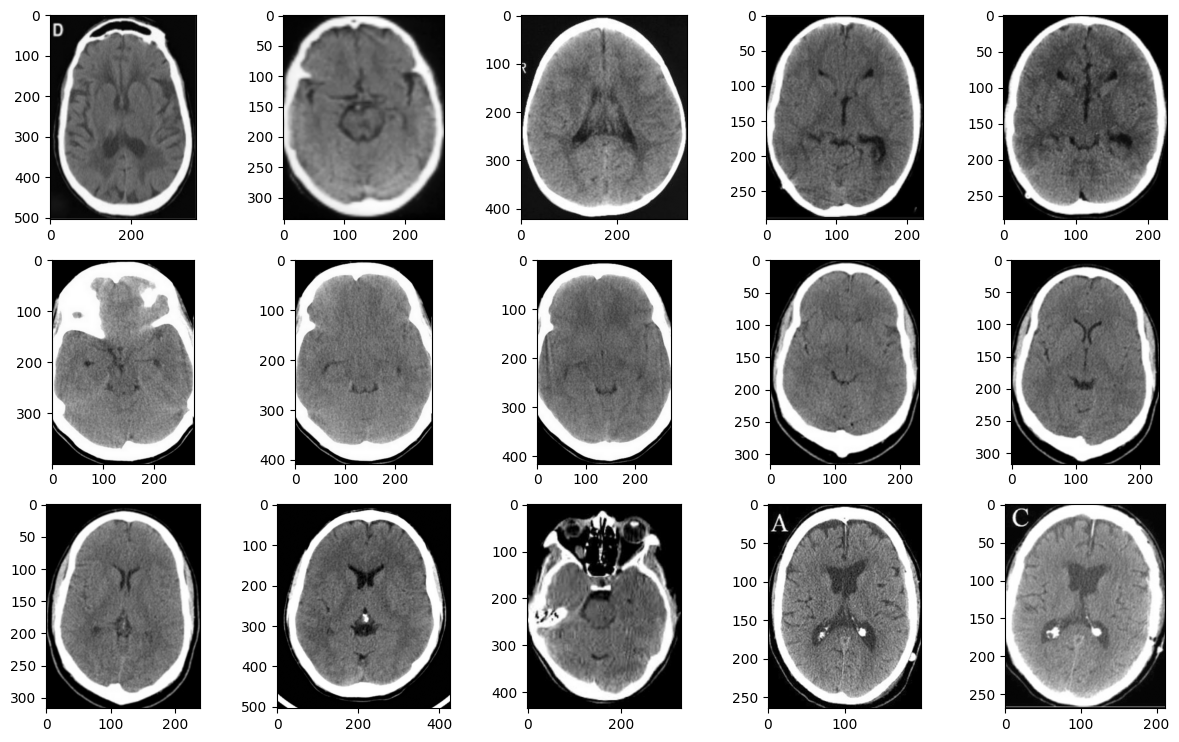

In [124]:
# Display example of normal images
normal = labels[labels['hemorrhage'] == 0]

rows, columns = 3, 5
fig = plt.figure(figsize=(15, 9))
for i in range(1, rows * columns + 1):
    fig.add_subplot(rows, columns, i)
    plt.imshow(images[normal.index[i]], cmap='gray')
plt.show()

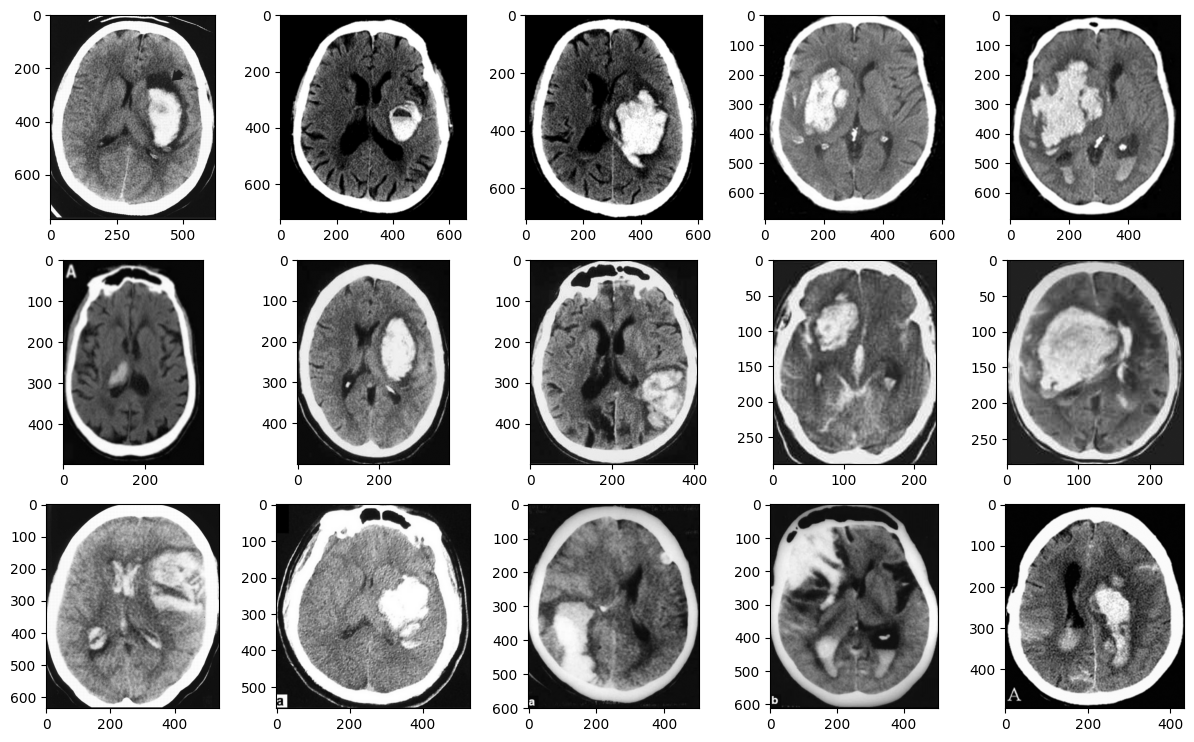

In [125]:
# Display example of images with hemorrhage
hemorrhage = labels[labels['hemorrhage'] == 1]

rows, columns = 3, 5
fig = plt.figure(figsize=(15, 9))
for i in range(1, rows * columns + 1):
    fig.add_subplot(rows, columns, i)
    plt.imshow(images[hemorrhage.index[i]], cmap='gray')

plt.show()

In [132]:
def apply_augmentation(image):

    image = Image.fromarray(image)
    
    angle=random.randint(-20,20)
    augmented_image=image.rotate(angle)
    
    if(random.random()>0.5):
        augmented_image=augmented_image.transpose(Image.FLIP_LEFT_RIGHT)
    
    brightness_factor=random.uniform(0.85,1.15)
    enhanced_image= ImageEnhance.Brightness(augmented_image).enhance(brightness_factor)
    
    contrast_factor = random.uniform(0.85, 1.15)
    enhanced_image = ImageEnhance.Contrast(enhanced_image).enhance(contrast_factor)
    
    color_image = ImageEnhance.Color(enhanced_image).enhance(random.uniform(0.8, 1.2))
    
    # nearest-neighbor
    
    scale_factor=random.uniform(0.8,1.2)
    new_size=(int(color_image.width * scale_factor),int(color_image.height * scale_factor))
    
    new_image=color_image.resize(new_size,Image.NEAREST)
    
    
    return new_image

In [134]:
# Augmenting the dataset
augmented_images = []
augmented_labels = pd.DataFrame(columns=['id', 'hemorrhage'])

AUGMENTATIONS_PER_IMAGE = 5

for i, image in enumerate(images):
    for j in range(AUGMENTATIONS_PER_IMAGE):
        augmented_image = apply_augmentation(image)
        augmented_images.append(augmented_image)
        
        # Get the label for the original image
        label = labels.iloc[i]['hemorrhage']

        augmented_labels.loc[len(augmented_labels)] = [f"A{i}_{j}",label] # in case of saving the image, the label is set here


In [68]:
augmented_labels.head()

,id,hemorrhage
0,A0_0,1
1,A0_1,1
2,A0_2,1
3,A0_3,1
4,A0_4,1


In [135]:
augmented_labels.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1000 entries, 0 to 999
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   id          1000 non-null   object
 1   hemorrhage  1000 non-null   int64 
dtypes: int64(1), object(1)
memory usage: 23.4+ KB


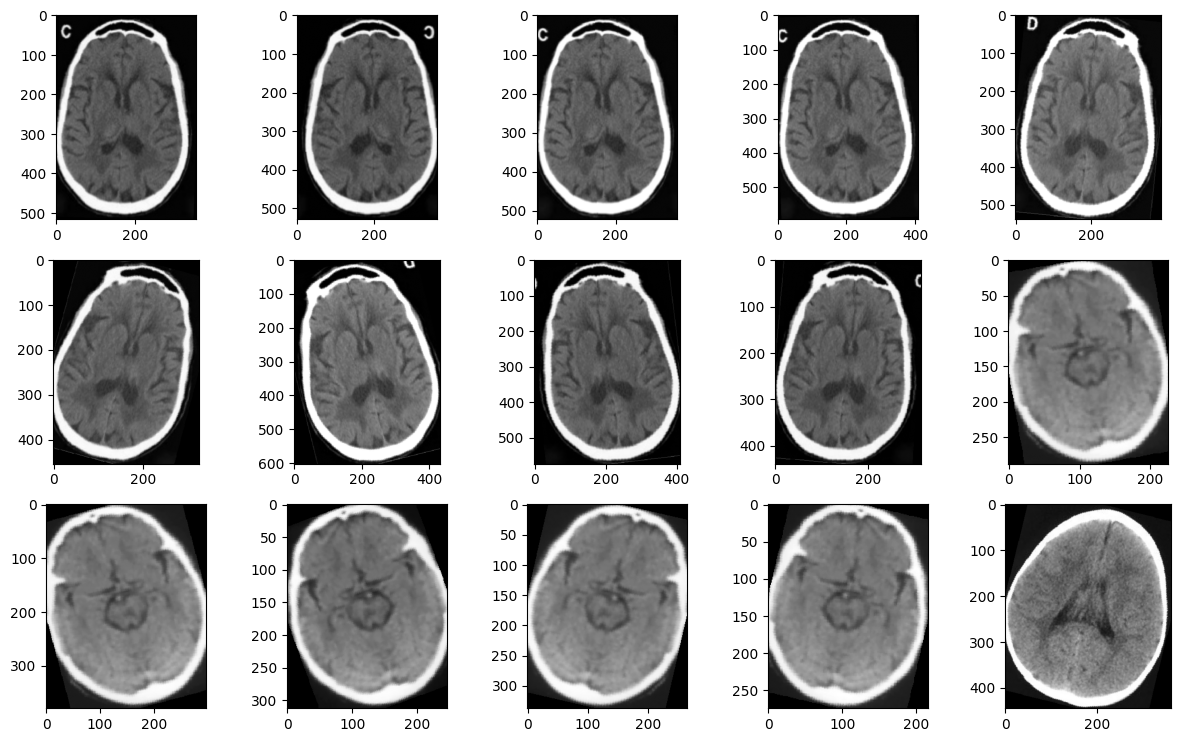

In [136]:
# Display example of augmented images without hemorrhage
hemorrhage = augmented_labels[augmented_labels['hemorrhage'] == 0]

rows, columns = 3, 5
fig = plt.figure(figsize=(15, 9))
for i in range(1, rows * columns + 1):
    fig.add_subplot(rows, columns, i)
    plt.imshow(augmented_images[hemorrhage.index[i]], cmap='gray')
plt.show()

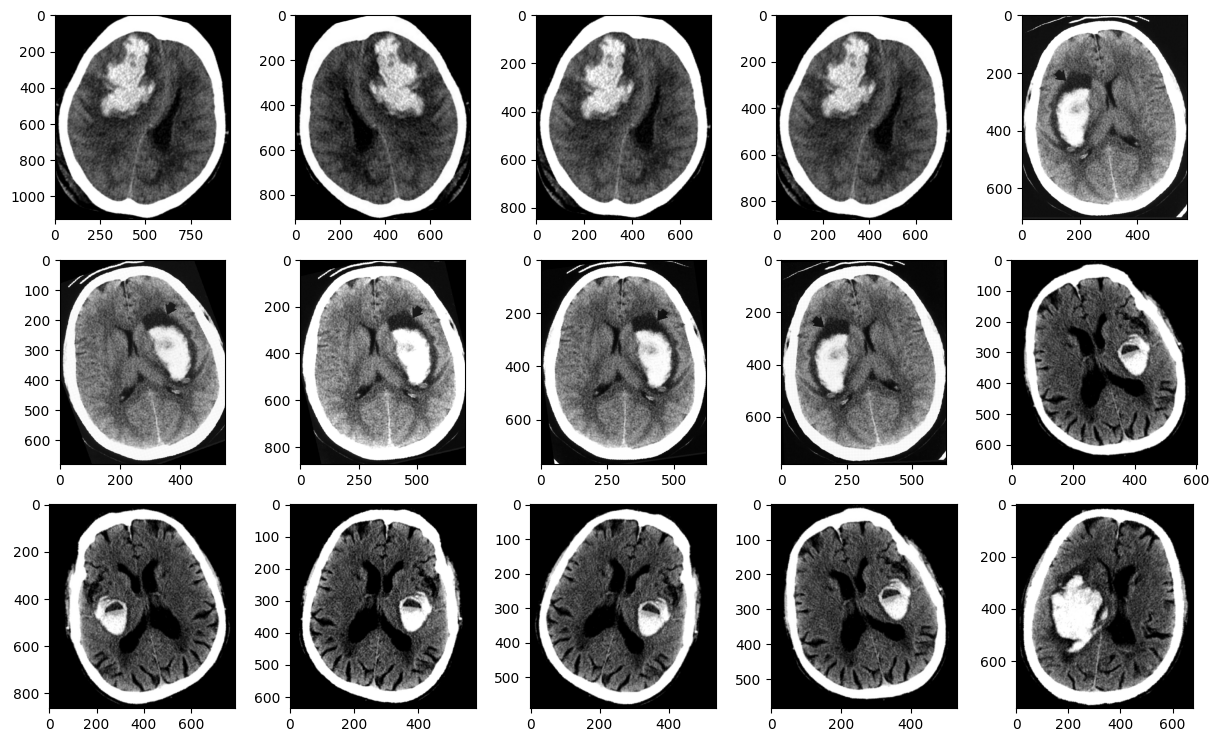

In [137]:
# Display example of augmented images with hemorrhage
hemorrhage = augmented_labels[augmented_labels['hemorrhage'] == 1]

rows, columns = 3, 5
fig = plt.figure(figsize=(15, 9))
for i in range(1, rows * columns + 1):
    fig.add_subplot(rows, columns, i)
    plt.imshow(augmented_images[hemorrhage.index[i]], cmap='gray')
plt.show()

In [138]:
original_labels = labels["hemorrhage"].tolist()
augmented_labels_list = augmented_labels["hemorrhage"].tolist()

images = [Image.fromarray(img) for img in images]

all_images = images + augmented_images
all_labels = original_labels + augmented_labels_list

In [139]:
class CTDataset(Dataset):
    def __init__(self, images, labels, transform=None):
        self.images = images
        self.labels = labels
        self.transform = transform
        
    def __len__(self):
        return len(self.images)
    
    def __getitem__(self, idx):
        img = self.images[idx]   # already PIL Image
        label = torch.tensor(self.labels[idx], dtype=torch.long)

        if self.transform:
            img = self.transform(img)

        return img, label


In [140]:
transform = transforms.Compose([
    transforms.Resize((224,224)), 
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5], std=[0.5]) 
])


images = [Image.fromarray(img) if isinstance(img, np.ndarray) else img for img in images]
augmented_images = [Image.fromarray(img) if isinstance(img, np.ndarray) else img for img in augmented_images]

full_dataset = CTDataset(all_images, all_labels, transform=transform)

In [145]:
# devide into train and validation sets
train_size = int(0.8 * len(full_dataset))
val_size = len(full_dataset) - train_size

train_dataset, val_dataset = random_split(full_dataset, [train_size, val_size])
test_dataset = CTDataset(images, original_labels, transform=transform)

batch_size = 16

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)


test_loader  = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

# Simple CNN

In [142]:
class SimpleCNN(nn.Module):
    def __init__(self):
        super(SimpleCNN, self).__init__()
        self.conv_layers = nn.Sequential(
            nn.Conv2d(1, 32, kernel_size=3, padding=1),
            nn.ReLU(), #original size 224, getting halved by MaxPool2d
            nn.MaxPool2d(2),  # 112
            nn.Conv2d(32, 64, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2),  # 56
            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2)   # 28
        )
        self.fc_layers = nn.Sequential(
            nn.Flatten(),
            nn.Linear(128*28*28, 128),
            nn.ReLU(),
            nn.Linear(128, 2)
        )
        
    def forward(self, x):
        x = self.conv_layers(x)
        x = self.fc_layers(x)
        return x

In [143]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

In [ ]:

model = SimpleCNN().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.0001)

num_epochs = 100


best_loss = float('inf')
patience = 7
counter = 0

for epoch in range(num_epochs):
    # -------- TRAIN --------
    model.train()
    train_loss = 0
    correct = 0
    total = 0
    
    for imgs, labels in train_loader:
        imgs, labels = imgs.to(device), labels.to(device)
        
        optimizer.zero_grad()
        outputs = model(imgs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        
        train_loss += loss.item()
        _, predicted = torch.max(outputs, 1)
        correct += (predicted == labels).sum().item()
        total += labels.size(0)

    train_loss /= len(train_loader)
    train_acc = correct / total

    # -------- VALIDATE --------
    model.eval()
    val_loss = 0

    with torch.no_grad():
        for imgs, labels in val_loader:
            imgs, labels = imgs.to(device), labels.to(device)
            outputs = model(imgs)
            loss = criterion(outputs, labels)
            val_loss += loss.item()

    val_loss /= len(val_loader)

    # -------- EARLY STOPPING --------
    if val_loss < best_loss:
        best_loss = val_loss
        counter = 0
        torch.save(model.state_dict(), "best.pt") # save the best model
    else:
        counter += 1
        if counter >= patience:
            print("Early stopping triggered")
            break

    print(f"Epoch {epoch+1}/{num_epochs}, "
          f"Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f}, "
          f"Val Loss: {val_loss:.4f}")


Epoch 1/100, Train Loss: 0.4801, Train Acc: 0.7635, Val Loss: 0.4912
Epoch 2/100, Train Loss: 0.3092, Train Acc: 0.8708, Val Loss: 0.3898
Epoch 3/100, Train Loss: 0.2635, Train Acc: 0.8802, Val Loss: 0.3378
Epoch 4/100, Train Loss: 0.2017, Train Acc: 0.9302, Val Loss: 0.2972
Epoch 5/100, Train Loss: 0.1700, Train Acc: 0.9344, Val Loss: 0.2694
Epoch 6/100, Train Loss: 0.1227, Train Acc: 0.9552, Val Loss: 0.3438
Epoch 7/100, Train Loss: 0.0949, Train Acc: 0.9698, Val Loss: 0.2056
Epoch 8/100, Train Loss: 0.0735, Train Acc: 0.9781, Val Loss: 0.2733
Epoch 9/100, Train Loss: 0.0665, Train Acc: 0.9760, Val Loss: 0.2532
Epoch 10/100, Train Loss: 0.0391, Train Acc: 0.9896, Val Loss: 0.1568
Epoch 11/100, Train Loss: 0.0236, Train Acc: 0.9979, Val Loss: 0.1906
Epoch 12/100, Train Loss: 0.0177, Train Acc: 0.9969, Val Loss: 0.1989
Epoch 13/100, Train Loss: 0.0151, Train Acc: 0.9979, Val Loss: 0.1987
Epoch 14/100, Train Loss: 0.0100, Train Acc: 0.9990, Val Loss: 0.1828
Epoch 15/100, Train Loss: 0.0

In [146]:
model.eval()
all_preds = []
all_labels = []

with torch.no_grad():
    for imgs, labels in test_loader:
        imgs, labels = imgs.to(device), labels.to(device)
        outputs = model(imgs)
        _, predicted = torch.max(outputs, 1)
        all_preds.extend(predicted.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

from sklearn.metrics import accuracy_score, precision_score, recall_score
print("Test Accuracy:", accuracy_score(all_labels, all_preds))
print("Test Precision:", precision_score(all_labels, all_preds))
print("Test Recall:", recall_score(all_labels, all_preds))

Test Accuracy: 0.995
Test Precision: 0.9900990099009901
Test Recall: 1.0


To load the saved model `best.pt`:

```
model = SimpleCNN().to(device)
model.load_state_dict(torch.load("cnn_hemorrhage.pth"))
model.eval()  # important for inference
```